In [39]:
%config Completer.use_jedi = False


In [1]:
import pandas as pd

import datetime as dt

import nsepy

from Dashboards.helpers.nse import nse_load_options, load_underlying

from Dashboards.helpers.probability import calculate_period_delta, evaluate_pairs, generate_pairs

In [2]:
indices = ['NIFTY', 'BANKNIFTY']

## Unrealizesed PNL Report

In [14]:
positions_df = pd.read_excel('Data/unrealizedPnl_report_2122_Future & Options.xlsx', skiprows=5, header=1)
positions_df

,Scrip Name,Scrip Code,Unrealized P&L,Unrealized P&L %,ISIN,Scrip Opt,Buy/Sell,Open Qty,Avg Rate,Open Amt,Closing Rate Exchange,Closing Rate Date,Closing Rate,Closing Amt
0,BANKNIFTY,BANKNIFTY,-9793.75,-100.0,NaN,CE,Buy,25,₹ 391.75,"₹ 9,793.75",FON,21/12/2021,0.0,–
1,BANKNIFTY,BANKNIFTY,-12098.75,-100.0,NaN,PE,Buy,25,₹ 483.95,"₹ 12,098.75",FON,21/12/2021,0.0,–
2,INFOSYS LTD.,500209,-6750.00,-100.0,INE009A01021,CE,Buy,300,₹ 22.50,"₹ 6,750.00",FON,21/12/2021,0.0,–
3,INFOSYS LTD.,500209,-6900.00,-100.0,INE009A01021,PE,Buy,300,₹ 23.00,"₹ 6,900.00",FON,21/12/2021,0.0,–
4,NIFTY,NIFTY,-5552.50,-100.0,NaN,CE,Buy,50,₹ 111.05,"₹ 5,552.50",FON,21/12/2021,0.0,–
5,NIFTY,NIFTY,-7750.00,-100.0,NaN,PE,Buy,50,₹ 155.00,"₹ 7,750.00",FON,21/12/2021,0.0,–
6,RELIANCE,500325,-8625.00,-100.0,INE002A01018,CE,Buy,250,₹ 34.50,"₹ 8,625.00",FON,21/12/2021,0.0,–
7,RELIANCE,500325,-6437.50,-100.0,INE002A01018,PE,Buy,250,₹ 25.75,"₹ 6,437.50",FON,21/12/2021,0.0,–


## Trades Report

In [15]:
# Skip the first few lines it contains the letterhead
trades_df = pd.read_excel('Data/trade_report_2122_NSE FO.xlsx', skiprows=5, header=1)

trades_df['Date'] = pd.to_datetime(trades_df['Date'], dayfirst=True)
trades_df['Expiry'] = pd.to_datetime(trades_df['Expiry'], dayfirst=True)

# Remove the Rupee symbol, and replace the comma before converting it to float
trades_df['Price'] = pd.to_numeric(trades_df['Price'].apply(lambda x: x[3:].replace(',', '')))

trades_df['option_type'] = trades_df['Instrument Type'].str[9:].replace({'Put':'PE', 
                                                                         'Call':'CE'})

trades_df.loc[trades_df['Side']=='Sell', 'Quantity']*=-1

trades_df['option_id'] = trades_df.Company + trades_df.Strike.apply(lambda strike: "%.0f"%strike) + trades_df.option_type + trades_df.Expiry.dt.strftime('_%d-%b')

In [16]:
trades_df

,Date,Company,Amount,Segment,Scrip Code,Instrument Type,Strike,Expiry,Trade Num,Trade Time,Side,Quantity,Price,option_type,option_id
0,2021-12-21,RELIANCE,"₹ 8,625.00",NSE FO,500325,European Call,2340.0,2021-12-30,800690304,12:30:12,Buy,250.0,34.50,CE,RELIANCE2340CE_30-Dec
1,2021-12-21,RELIANCE,"₹ 6,437.50",NSE FO,500325,European Put,2320.0,2021-12-30,800684584,12:27:28,Buy,250.0,25.75,PE,RELIANCE2320PE_30-Dec
2,2021-12-21,RELIANCE,"₹ 8,675.00",NSE FO,500325,European Put,2340.0,2021-12-30,800684937,12:27:38,Buy,250.0,34.70,PE,RELIANCE2340PE_30-Dec
3,2021-12-21,RELIANCE,"₹ 8,750.00",NSE FO,500325,European Put,2340.0,2021-12-30,800775782,13:08:29,Sell,-250.0,35.00,PE,RELIANCE2340PE_30-Dec
4,2021-12-21,BANKNIFTY,"₹ 9,793.75",NSE FO,BANKNIFTY,European Call,35100.0,2021-12-30,700194846,09:53:31,Buy,25.0,391.75,CE,BANKNIFTY35100CE_30-Dec
5,2021-12-21,BANKNIFTY,"₹ 12,098.75",NSE FO,BANKNIFTY,European Put,34700.0,2021-12-30,700190968,09:51:20,Buy,25.0,483.95,PE,BANKNIFTY34700PE_30-Dec
6,2021-12-21,NIFTY,"₹ 5,552.50",NSE FO,NIFTY,European Call,17000.0,2021-12-30,100585035,10:00:03,Buy,50.0,111.05,CE,NIFTY17000CE_30-Dec
7,2021-12-21,NIFTY,"₹ 7,750.00",NSE FO,NIFTY,European Put,16800.0,2021-12-30,100573905,09:58:36,Buy,50.0,155.00,PE,NIFTY16800PE_30-Dec
8,2021-12-20,NIFTY,"₹ 16,500.00",NSE FO,NIFTY,European Put,16950.0,2021-12-30,100286590,09:28:56,Sell,-50.0,330.00,PE,NIFTY16950PE_30-Dec
9,2021-12-20,INFOSYS LTD.,"₹ 6,750.00",NSE FO,500209,European Call,1820.0,2021-12-30,300625092,11:43:06,Buy,300.0,22.50,CE,INFOSYS LTD.1820CE_30-Dec


In [17]:
company_symbol_lookup = {'INFOSYS LTD.': 'INFY', 
                         'RELIANCE':'RELIANCE'}

**Convert Trades into open positions**

In [40]:
positions = {}
position_costs = {}
for ix, trade in trades_df.sort_values('Date', ascending=False).iterrows():
    option_id = trade.option_id
    
    if option_id not in positions:
#         if trade.Quantity > 0:
        positions[option_id] = trade.Quantity
        position_costs[option_id] = trade.Quantity*trade.Price
        
    else:
        positions[option_id] += trade.Quantity
        position_costs[option_id] += trade.Quantity*trade.Price
        if positions[option_id]==0:
            positions.pop(option_id)
            position_costs.pop(option_id)
    

positions_df = pd.DataFrame({"option_id":positions.keys(), "qty":positions.values(), "cost":position_costs.values()})

positions_df['avg_price'] = positions_df.cost/positions_df.qty

positions_df = pd.merge(trades_df[['Company', 'Strike','Expiry', 'option_type', 'option_id']].drop_duplicates(), positions_df, on='option_id', how='right')

positions_df.columns = map(str.lower, positions_df.columns)

positions_df = positions_df[positions_df.qty>0]

positions_df = positions_df[positions_df.expiry>dt.datetime.today()]

positions_df['lot_size'] = 0
positions_df['last_price'] = 0


positions_df = positions_df.rename({'company':'underlying', 
                                    'strike':'strike_price'},
                                   axis=1)

**Update the current value of positions**

In [61]:
for idx, contract in positions_df[['underlying', 'expiry', 'option_type', 'strike_price', 'lot_size']].iterrows():
#     contract = contract_row[1]
    
    if contract['underlying'] in indices:
        instrument_type = 'OPTIDX'
        symbol = contract['underlying']
    else:
        instrument_type = 'OPTSTK'
        symbol = company_symbol_lookup[contract['underlying']]
        
    contract_quote = nsepy.get_quote(symbol=symbol, series='EQ', instrument=instrument_type, expiry=contract['expiry'], strike=contract['strike_price'], option_type=contract['option_type'])
    positions_df.loc[idx, 'lot_size'] = float(contract_quote['data'][0]['marketLot'])
    positions_df.loc[idx, 'last_price'] = float(contract_quote['data'][0]['lastPrice'])


positions_df['cost'] = positions_df.qty*positions_df.avg_price

positions_df['value'] = positions_df.qty*positions_df.last_price

positions_df = positions_df[positions_df.expiry>dt.datetime.today()]

In [62]:
contract

underlying             INFOSYS LTD.
expiry          2021-12-30 00:00:00
option_type                      CE
strike_price                 1820.0
lot_size                        300
Name: 8, dtype: object

In [63]:
positions_df.sort_values('strike_price')

,underlying,strike_price,expiry,option_type,option_id,qty,cost,avg_price,lot_size,last_price,value
7,INFOSYS LTD.,1800.0,2021-12-30,PE,INFOSYS LTD.1800PE_30-Dec,300.0,6900.00,23.00,300,5.25,1575.00
8,INFOSYS LTD.,1820.0,2021-12-30,CE,INFOSYS LTD.1820CE_30-Dec,300.0,6750.00,22.50,300,40.80,12240.00
1,RELIANCE,2320.0,2021-12-30,PE,RELIANCE2320PE_30-Dec,250.0,6437.50,25.75,250,11.45,2862.50
0,RELIANCE,2340.0,2021-12-30,CE,RELIANCE2340CE_30-Dec,250.0,8625.00,34.50,250,47.60,11900.00
5,NIFTY,16800.0,2021-12-30,PE,NIFTY16800PE_30-Dec,50.0,7750.00,155.00,50,51.85,2592.50
4,NIFTY,17000.0,2021-12-30,CE,NIFTY17000CE_30-Dec,50.0,5552.50,111.05,50,198.80,9940.00
3,BANKNIFTY,34700.0,2021-12-30,PE,BANKNIFTY34700PE_30-Dec,25.0,12098.75,483.95,25,161.80,4045.00
2,BANKNIFTY,35100.0,2021-12-30,CE,BANKNIFTY35100CE_30-Dec,25.0,9793.75,391.75,25,563.65,14091.25


Total amount Invested:

In [64]:
positions_df.cost.sum()

63907.5

Current Value of investments:

In [65]:
positions_df.value.sum()

59246.25

In [66]:
target_rate = 1.125

## Positions by Underlying

In [67]:
positions_by_underlying = positions_df.groupby(['underlying']).agg(qty=pd.NamedAgg(column="qty", aggfunc="sum"),  
                                                                   lot_size=pd.NamedAgg(column="lot_size", aggfunc="first"),
                                                                   current_value=pd.NamedAgg(column="value", aggfunc="sum"),
                                                                   initial_investment=pd.NamedAgg(column="cost", aggfunc="sum") ).reset_index()

positions_by_underlying['num_pairs'] = positions_by_underlying.qty/positions_by_underlying.lot_size/2

positions_by_underlying['breakeven'] = positions_by_underlying['initial_investment']/(positions_by_underlying['qty']/2)
positions_by_underlying['target'] = target_rate*positions_by_underlying['breakeven']

# positions_by_underlying['current_value'] = positions_by_underlying['current_value']*positions_by_underlying['qty']


positions_by_underlying['change'] = (positions_by_underlying['current_value']-positions_by_underlying['initial_investment'])/positions_by_underlying['initial_investment']

positions_by_underlying

,underlying,qty,lot_size,current_value,initial_investment,num_pairs,breakeven,target,change
0,BANKNIFTY,50.0,25,18136.25,21892.5,1.0,875.70,985.16250,-0.171577
1,INFOSYS LTD.,600.0,300,13815.00,13650.0,1.0,45.50,51.18750,0.012088
2,NIFTY,100.0,50,12532.50,13302.5,1.0,266.05,299.30625,-0.057884
3,RELIANCE,500.0,250,14762.50,15062.5,1.0,60.25,67.78125,-0.019917


Target Value

In [37]:
sum(positions_by_underlying.target*positions_by_underlying.qty/2)

71895.9375

## Positions by Underlying and Expiry

In [237]:
positions_by_expiry = positions_df.groupby(['underlying', 'expiry']).agg(qty=pd.NamedAgg(column="qty", aggfunc="sum"),  
                                                                         lot_size=pd.NamedAgg(column="lot_size", aggfunc="first"),
                                                                         current_value=pd.NamedAgg(column="value", aggfunc="sum"),
                                                                         initial_investment=pd.NamedAgg(column="cost", aggfunc="sum") ).reset_index()

# positions_by_expiry['target'] = target_rate*positions_by_expiry.initial_investment/positions_by_expiry.qty

positions_by_expiry['num_pairs'] = positions_by_expiry.qty/positions_by_expiry.lot_size/2


# positions_by_expiry['current_value'] = positions_by_expiry['current_value']*positions_by_expiry['qty']

# positions_by_expiry['target'] = target_rate*positions_by_expiry['initial_investment']/positions_by_expiry['num_pairs']/positions_by_expiry.lot_size


positions_by_expiry['target'] = target_rate*positions_by_expiry['initial_investment']/(positions_by_expiry['qty']/2)

positions_by_expiry['change'] = (positions_by_expiry['current_value']-positions_by_expiry['initial_investment'])/positions_by_expiry['initial_investment']

positions_by_expiry

,underlying,expiry,qty,lot_size,current_value,initial_investment,num_pairs,target,change
0,BANKNIFTY,2021-12-30,50.0,25,17722.5,21892.5,1.0,963.270,-0.190476
1,INFOSYS LTD.,2021-12-30,600.0,300,10650.0,13650.0,1.0,50.050,-0.219780
2,NIFTY,2021-12-30,100.0,50,11532.5,13302.5,1.0,292.655,-0.133058
3,RELIANCE,2021-12-30,500.0,250,15037.5,15062.5,1.0,66.275,-0.001660


## Positions by Pairs

In [174]:
positions_df

,underlying,strike_price,expiry,option_type,option_id,qty,cost,avg_price,lot_size,last_price,value
0,RELIANCE,2340.0,2021-12-30,CE,RELIANCE2340CE_30-Dec,250.0,8625.00,34.50,250,38.95,9737.50
1,RELIANCE,2320.0,2021-12-30,PE,RELIANCE2320PE_30-Dec,250.0,6437.50,25.75,250,19.20,4800.00
2,BANKNIFTY,35100.0,2021-12-30,CE,BANKNIFTY35100CE_30-Dec,25.0,9793.75,391.75,25,343.35,8583.75
3,BANKNIFTY,34700.0,2021-12-30,PE,BANKNIFTY34700PE_30-Dec,25.0,12098.75,483.95,25,369.80,9245.00
4,NIFTY,17000.0,2021-12-30,CE,NIFTY17000CE_30-Dec,50.0,5552.50,111.05,50,112.90,5645.00
5,NIFTY,16800.0,2021-12-30,PE,NIFTY16800PE_30-Dec,50.0,7750.00,155.00,50,113.95,5697.50
7,INFOSYS LTD.,1800.0,2021-12-30,PE,INFOSYS LTD.1800PE_30-Dec,300.0,6900.00,23.00,300,11.35,3405.00
8,INFOSYS LTD.,1820.0,2021-12-30,CE,INFOSYS LTD.1820CE_30-Dec,300.0,6750.00,22.50,300,23.10,6930.00


In [175]:
for u, e in positions_df[['underlying', 'expiry']].drop_duplicates().to_dict(orient='split')['data']:
    
    position_group = positions_df[(positions_df['underlying'] == u) & (positions_df['expiry'] == e)]

    # Separate out Call and Put option
    ce_positions = position_group[position_group['option_type']=='CE']
    pe_positions = position_group[position_group['option_type']=='PE']

    # Convert to dict for easier iteration
    pe_positions = pe_positions.sort_values(by='strike_price', ascending=False).to_dict(orient='records')
    ce_positions = ce_positions.sort_values(by='strike_price').to_dict(orient='records')

    position_pairs = []

    for pe_position in pe_positions:
        for ce_position in ce_positions:
            print(ce_position['option_id'],pe_position['option_id'])

RELIANCE2340CE_30-Dec RELIANCE2320PE_30-Dec
BANKNIFTY35100CE_30-Dec BANKNIFTY34700PE_30-Dec
NIFTY17000CE_30-Dec NIFTY16800PE_30-Dec
INFOSYS LTD.1820CE_30-Dec INFOSYS LTD.1800PE_30-Dec


In [177]:
company_symbol_lookup[u]

'INFY'

In [20]:
# DATA_ROOT = 'QmVmo99nn2wMjShNGi5CDPEqzRWtYxWRrjD5XTsfQiCZD3'
with open("datastore/nse.dataroot") as f:
    DATA_ROOT = f.readline()
DATA_ROOT

'QmRnF1pCXfGEFbYwgTFJNJjSt3UL2RsftzqbLNFJ86GAmG'

In [21]:
underlying_df = load_underlying(u, DATA_ROOT)

In [22]:
underlying_df

,Close,High,Low,Open,Turnover,Volume
Date,,,,,,
2018-01-02,10442.20,10495.20,10404.65,10477.55,8.665470e+03,158092430.0
2018-01-03,10443.20,10503.60,10429.55,10482.65,9.541600e+03,172516859.0
2018-01-04,10504.80,10513.00,10441.45,10469.40,9.561950e+03,180257392.0
2018-01-05,10558.85,10566.10,10520.10,10534.25,1.030622e+04,186469717.0
2018-01-08,10623.60,10631.20,10588.55,10591.70,9.907270e+03,174181231.0
...,...,...,...,...,...,...
2021-12-17,16985.20,17298.15,16966.45,17276.00,3.132691e+11,354591366.0
2021-12-17,16985.20,17298.15,16966.45,17276.00,3.132691e+11,354591366.0
2021-12-17,16985.20,17298.15,16966.45,17276.00,3.132691e+11,354591366.0


In [23]:
delta_df = calculate_period_delta(underlying_df, 5)
delta_df

,delta,delta_max,delta_min
Date,,,
2018-01-08,0.017372,0.014665,-0.006958
2018-01-09,0.018558,0.016837,-0.005066
2018-01-10,0.012128,0.018124,-0.002670
2018-01-11,0.008746,0.012374,-0.001343
2018-01-12,0.005427,0.009319,-0.000297
...,...,...,...
2021-12-17,0.000000,0.001282,-0.017918
2021-12-17,0.000000,0.001282,-0.017918
2021-12-17,0.000000,0.001282,-0.017918


In [24]:
def evaluate_postions(options_data, underlying_period_delta, underlying_price, expected_rate=0.1):
    # Separate out Call and Put option
    ce_df = options_data[options_data['option_type']=='CE']
    pe_df = options_data[options_data['option_type']=='PE']
    
    # Sort by Strike
    ce_df = ce_df.sort_values('strike_price')
    pe_df = pe_df.sort_values('strike_price')
    

    # Maximum Change required to break even on position
    ce_df['change_breakeven'] = ((ce_df['strike_price'] + ce_df['avg_price'] - underlying_price)/underlying_price).values
    pe_df['change_breakeven'] = ((pe_df['strike_price'] - pe_df['avg_price'] - underlying_price)/underlying_price).values

    # Change percent required to close ITM
    ce_df['change_itm'] = ((ce_df['strike_price'] - underlying_price)/underlying_price).values
    pe_df['change_itm'] = ((pe_df['strike_price'] - underlying_price)/underlying_price).values

    # Position cost per lot
    ce_df['position_cost'] = ce_df['qty']*ce_df['avg_price']
    pe_df['position_cost'] = pe_df['qty']*pe_df['avg_price']
    
    
    delta_mean = underlying_period_delta['delta'].mean()
    delta_std = underlying_period_delta['delta'].std()
    
    # Calculate underlying price after sigma change in either direction
    sigma_high = underlying_price*(1+delta_mean+delta_std)
    sigma_low = underlying_price*(1+delta_mean-delta_std)
    
    # Profits when underlying expires at mean +/- std
    ce_df['sigma_returns'] = ce_df['qty']*(sigma_high - ce_df['strike_price'])
    pe_df['sigma_returns'] = pe_df['qty']*(pe_df['strike_price'] - sigma_low)
    
    # Probabilty of breaking even within the period due to volatility
    pe_df['p_volatility_breakeven'] = pe_df.change_breakeven.apply(lambda x:  (underlying_period_delta.delta_min<x).mean())
    ce_df['p_volatility_breakeven'] = ce_df.change_breakeven.apply(lambda x:  (underlying_period_delta.delta_max>x).mean())
    
    # Probability of closing in the money at expiry
    pe_df['p_expiry_itm'] = pe_df.change_itm.apply(lambda x:  (x>underlying_period_delta.delta).mean())
    ce_df['p_expiry_itm'] = ce_df.change_itm.apply(lambda x:  (x<underlying_period_delta.delta).mean())
    
    # Probability of breaking even at expiry
    pe_df['p_expiry_breakeven'] = pe_df.change_breakeven.apply(lambda x:  (x>underlying_period_delta.delta).mean())
    ce_df['p_expiry_breakeven'] = ce_df.change_breakeven.apply(lambda x:  (x<underlying_period_delta.delta).mean()) 
    
    
    return ce_df, pe_df


In [25]:
def generate_pairs(pe_positions, ce_positions, fitler_sigma=True, brokerage=20):
    
    # Convert to dict for easier iteration
    pe_positions = pe_positions.to_dict(orient='records')
    ce_positions = ce_positions.to_dict(orient='records')
    
    position_pairs = []

    for pe_position in pe_positions:

        if pe_position['sigma_returns'] <= 0 & fitler_sigma:
            continue
        for ce_position in ce_positions:
            if ce_position['sigma_returns'] <= 0 & fitler_sigma:
                continue

#             pair_cost = pe_position['position_cost'] + ce_position['position_cost']
            position_pair = {'pair': pe_position['underlying']+str(pe_position['strike_price'])+pe_position['option_type']+'-'+ce_position['underlying']+str(ce_position['strike_price'])+ce_position['option_type']}
            
            position_pair['pe_price'] = pe_position['last_price']
            position_pair['ce_price'] = ce_position['last_price']
            position_pair['pe_buy_price'] = pe_position['avg_price']
            position_pair['ce_buy_price'] = ce_position['avg_price']
            position_pair['capital_not_breakeven_probability'] = (1-pe_position['p_volatility_breakeven'])*(1-ce_position['p_volatility_breakeven'])
            position_pair['pe_strike_price'] = pe_position['strike_price']
            position_pair['ce_strike_price'] = ce_position['strike_price']
            position_pair['spread'] = ce_position['strike_price'] - pe_position['strike_price']
            position_pair['pe_probability_itm'] = pe_position['p_expiry_itm']
            position_pair['ce_probability_itm'] = ce_position['p_expiry_itm']
            position_pair['pair_otm_probability'] = (1-ce_position['p_expiry_itm'])*(1-pe_position['p_expiry_itm'])
            position_pair['lot_size'] = pe_position['lot_size']
            
            position_pairs.append(position_pair)


    position_pairs_df = pd.DataFrame(position_pairs)
    position_pairs_df['current_value'] = (position_pairs_df.ce_price+position_pairs_df.pe_price)*position_pairs_df.lot_size
    position_pairs_df['cost'] = (position_pairs_df.pe_buy_price+position_pairs_df.pe_buy_price)*position_pairs_df.lot_size + brokerage*4 # 4x brokerage because we're accounting for the selling brokerage as well
    
    return position_pairs_df
    
    


In [26]:
position_group

,underlying,strike_price,expiry,option_type,option_id,qty,cost,avg_price,lot_size,last_price,value
0,NIFTY,17050.0,2021-12-30,CE,NIFTY17050CE_30-Dec,50.0,9750.0,195.0,50,47.50,2375.0
3,NIFTY,16950.0,2021-12-30,PE,NIFTY16950PE_30-Dec,50.0,8575.0,171.5,50,391.15,19557.5


In [34]:
ce_positions, pe_positions = evaluate_postions(position_group, delta_df, underlying_price=16600)

In [35]:
pe_positions

,underlying,strike_price,expiry,option_type,option_id,qty,cost,avg_price,lot_size,last_price,value,change_breakeven,change_itm,position_cost,sigma_returns,p_volatility_breakeven,p_expiry_itm,p_expiry_breakeven
3,NIFTY,16950.0,2021-12-30,PE,NIFTY16950PE_30-Dec,50.0,8575.0,171.5,50,391.15,19557.5,0.010753,0.021084,8575.0,35760.947905,1.0,0.860442,0.662651


In [36]:
ce_positions

,underlying,strike_price,expiry,option_type,option_id,qty,cost,avg_price,lot_size,last_price,value,change_breakeven,change_itm,position_cost,sigma_returns,p_volatility_breakeven,p_expiry_itm,p_expiry_breakeven
0,NIFTY,17050.0,2021-12-30,CE,NIFTY17050CE_30-Dec,50.0,9750.0,195.0,50,47.5,2375.0,0.038855,0.027108,9750.0,-525.717387,0.073293,0.082329,0.038153


In [30]:
position_pairs_df = generate_pairs(pe_positions, ce_positions)

In [31]:
evaluate_pairs(position_pairs_df, underlying_close=, delta_df=delta_df)

,pair,pe_price,ce_price,pe_buy_price,ce_buy_price,capital_not_breakeven_probability,pe_strike_price,ce_strike_price,spread,pe_probability_itm,...,pair_otm_probability,lot_size,current_value,cost,target,pe_breakeven_change,ce_breakeven_change,pe_breakeven_probability,ce_breakeven_probability,pair_not_breakeven_probability
0,NIFTY16950.0PE-NIFTY17050.0CE,391.15,47.5,171.5,195.0,0.012081,16950.0,17050.0,100.0,0.15261,...,0.189727,50,21932.5,17230.0,361.83,-656.83,166.83,0.100402,0.564257,0.391994


In [21]:
positions_df.cost.sum()

101323.75

In [192]:
resp = nsepy.get_history(contract.instrument, start=today - dt.timedelta(days=4), end=today, index=True)

In [195]:
resp.iloc[-1]

Open        1.742490e+04
High        1.748980e+04
Low         1.718080e+04
Close       1.719670e+04
Volume      2.925265e+08
Turnover    2.310057e+11
Name: 2021-12-03, dtype: float64

In [180]:
nsepy.get_quote(symbol=contract['instrument'], series='EQ', instrument='FUTIDX', expiry=contract.expiry)

{'valid': 'false',
 'tradedDate': '03DEC2021',
 'eqLink': '',
 'data': [{}],
 'companyName': 'Nifty 50',
 'lastUpdateTime': '03-DEC-2021 15:30:27',
 'isinCode': None,
 'ocLink': '/marketinfo/sym_map/symbolMapping.jsp?symbol=NIFTY&instrument=-&date=-&segmentLink=17&symbolCount=2'}

### Recommend Pairs taking Avg Price into account

In [45]:
positions_df

,underlying,strike_price,expiry,option_type,option_id,qty,cost,avg_price,lot_size,last_price,value
0,NIFTY,17050.0,2021-12-30,CE,NIFTY17050CE_30-Dec,50.0,9750.0,195.0,50,47.50,2375.0
3,NIFTY,16950.0,2021-12-30,PE,NIFTY16950PE_30-Dec,50.0,8575.0,171.5,50,391.15,19557.5


In [50]:
for underlying in positions_df.underlying.unique():
    options_df, _ = nse_load_options(underlying=underlying)
    underlying_positions = positions_df[positions_df['underlying']==underlying]
    

In [81]:
for expiry in underlying_positions.expiry.unique():
    options_expiry_df = options_df[(options_df['Symbol']==underlying) & (options_df['Expiry']==expiry)].copy()
    options_expiry_df['avg_price'] = options_expiry_df['Close']
    underlying_expiry_positions = underlying_positions[underlying_positions['expiry']==expiry]
    
    underlying_expiry_positions.ex

In [78]:
options_df

468    391.15
Name: Close, dtype: float64

In [82]:
for ix, position in underlying_expiry_positions[['strike_price', 'qty', 'avg_price', 'lot_size']].iterrows():
    last_price = options_expiry_df.loc[options_expiry_df['Strike Price']==position['strike_price'], 'Close'].values[0]
    avg_price = (last_price*position['lot_size'] + position['avg_price']*position['qty'])/(position['lot_size']+position['qty'])
    options_expiry_df.loc[options_expiry_df['Strike Price']==position['strike_price'], 'avg_price'] = avg_price
    print(position['strike_price'], last_price, avg_price)

17050.0 47.5 121.25
16950.0 391.15 281.325


In [83]:
options_expiry_df

,Strike Price,Expiry,Option Type,Symbol,identifier,Open Interest,Change in OI,Change % in OI,Number of Contracts,impliedVolatility,...,Change,Change %,totalBuyQuantity,totalSellQuantity,bidQty,bidprice,askQty,askPrice,Underlying,avg_price
1,8000,2021-12-30,PE,NIFTY,OPTIDXNIFTY30-12-2021PE8000.00,1648.0,153.0,10.234114,587,149.23,...,0.30,33.333333,56450,23750,600,1.15,1200,1.20,16614.2,1.20
3,8500,2021-12-30,PE,NIFTY,OPTIDXNIFTY30-12-2021PE8500.00,222.5,19.0,9.336609,87,139.91,...,-1.05,-42.000000,17100,13600,100,1.30,2900,1.45,16614.2,1.45
8,9000,2021-12-30,CE,NIFTY,OPTIDXNIFTY30-12-2021CE9000.00,144.5,0.0,0.000000,1,0.00,...,-495.00,-6.145251,7100,7100,100,7531.50,100,7675.90,16614.2,7560.00
9,9100,2021-12-30,PE,NIFTY,OPTIDXNIFTY30-12-2021PE9100.00,280.5,0.0,0.000000,0,0.00,...,0.00,0.000000,150,0,150,0.10,0,0.00,16614.2,410.00
10,9200,2021-12-30,PE,NIFTY,OPTIDXNIFTY30-12-2021PE9200.00,112.5,0.0,0.000000,0,0.00,...,0.00,0.000000,150,0,150,0.10,0,0.00,16614.2,3.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,19850,2021-12-30,PE,NIFTY,OPTIDXNIFTY30-12-2021PE19850.00,3.0,0.0,0.000000,0,0.00,...,0.00,0.000000,7200,4100,650,3147.00,350,3459.50,16614.2,2655.35
986,19900,2021-12-30,CE,NIFTY,OPTIDXNIFTY30-12-2021CE19900.00,345.0,-20.0,-5.479452,118,42.98,...,0.05,1.960784,99000,6050,550,2.60,50,2.80,16614.2,2.60
987,19950,2021-12-30,PE,NIFTY,OPTIDXNIFTY30-12-2021PE19950.00,1.0,0.0,0.000000,0,0.00,...,0.00,0.000000,5600,4450,1850,3222.95,1000,3653.15,16614.2,2067.75
988,20000,2021-12-30,CE,NIFTY,OPTIDXNIFTY30-12-2021CE20000.00,17785.0,-546.0,-2.978561,5530,43.64,...,-0.40,-14.285714,140000,45050,250,2.40,50,2.50,16614.2,2.40


In [74]:
options_expiry_df[options_expiry_df['Strike Price']==position['strike_price']]

,Strike Price,Expiry,Option Type,Symbol,identifier,Open Interest,Change in OI,Change % in OI,Number of Contracts,impliedVolatility,Close,Change,Change %,totalBuyQuantity,totalSellQuantity,bidQty,bidprice,askQty,askPrice,Underlying
468,16950,2021-12-30,PE,NIFTY,OPTIDXNIFTY30-12-2021PE16950.00,1636.0,-318.0,-16.274309,2584,19.55,391.15,222.7,132.205402,16600,14100,50,379.0,50,391.15,16614.2


In [55]:
for position in underlying_positions[['strike_price', 'expiry', 'option_type']].to_dict(orient='records'):
    options_df[a
              ]

[{'strike_price': 17050.0,
  'expiry': Timestamp('2021-12-30 00:00:00'),
  'option_type': 'CE'},
 {'strike_price': 16950.0,
  'expiry': Timestamp('2021-12-30 00:00:00'),
  'option_type': 'PE'}]

In [38]:
underlying = 'NIFTY'
data_df, expiries = nse_load_options(underlying)

## Historical Analysis
Get historical data for everything

In [16]:
pe_hist = nsepy.get_history(symbol=underlying,
                                  start=today - dt.timedelta(days=15),
                                  end=today,
                                  index=True,
                                  option_type='PE',
                                  strike_price=put_strike,
                                  expiry_date=expiry.date())

ce_hist = nsepy.get_history(symbol=underlying,
                                  start=today - dt.timedelta(days=15),
                                  end=today,
                                  index=True,
                                  option_type='CE',
                                  strike_price=call_strike,
                                  expiry_date=expiry.date())

underlying_hist = nsepy.get_history(symbol=underlying,
                                  start=today - dt.timedelta(days=15),
                                  end=today,
                                  index=True,
                                  strike_price=call_strike,
                                  expiry_date=expiry.date())

Calculate the per day change 

In [34]:
pair_delta = (pe_hist.Close+ce_hist.Close).diff().iloc[1:]/(pe_hist.Open+ce_hist.Open).iloc[1:]

In [36]:
import matplotlib.pyplot as plt

In [78]:
pair_historical = pd.DataFrame({'Pair Premium': pe_hist.Close+ce_hist.Close, 'PE Premium': pe_hist.Close, 'CE Premium': ce_hist.Close, 'Underlying': underlying_hist.Close})

,Pair Premium,PE Premium,CE Premium,Underlying
Date,,,,
2021-11-12,2965.80,46.10,2919.70,38733.35
2021-11-15,2962.80,43.10,2919.70,38702.35
2021-11-16,2982.75,63.05,2919.70,38307.10
2021-11-17,2987.95,68.25,2919.70,38041.55
2021-11-18,2972.20,52.50,2919.70,37976.25
2021-11-23,951.25,96.60,854.65,37272.80
2021-11-24,998.10,62.85,935.25,37441.95
2021-11-25,899.50,37.35,862.15,37364.75
2021-11-26,607.90,415.95,191.95,36025.50


In [57]:
pair_premium = pe_hist.Close+ce_hist.Close

Pair Delta

In [75]:
pair_premium.diff() / abs(underlying_hist.Close.diff())

Date
2021-11-12          NaN
2021-11-15    -0.096774
2021-11-16     0.050474
2021-11-17     0.019582
2021-11-18    -0.241194
2021-11-22          NaN
2021-11-23   -14.034375
2021-11-24     0.276973
2021-11-25    -1.277202
2021-11-26    -0.217734
Name: Close, dtype: float64

In [56]:
import plotly.graph_objects as go

In [60]:
import plotly.express as px

**Premium Decay**

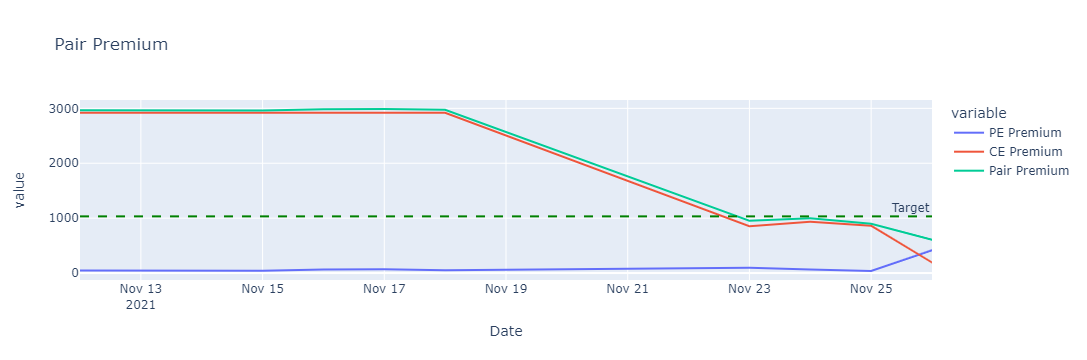

In [90]:
fig = px.line(pair_historical.dropna().reset_index(), x="Date", y=["PE Premium", "CE Premium", "Pair Premium"], title="Pair Premium")
fig.add_hline((1+target)*pair_position['cost']/pair_position['quantity'], line_dash="dash", line_color="green", annotation_text='Target')
fig.show()

# Kelly Criterion

Against losing on all pairs

In [93]:
import  numpy as np

### Capital Allocation

Not considering partial losses

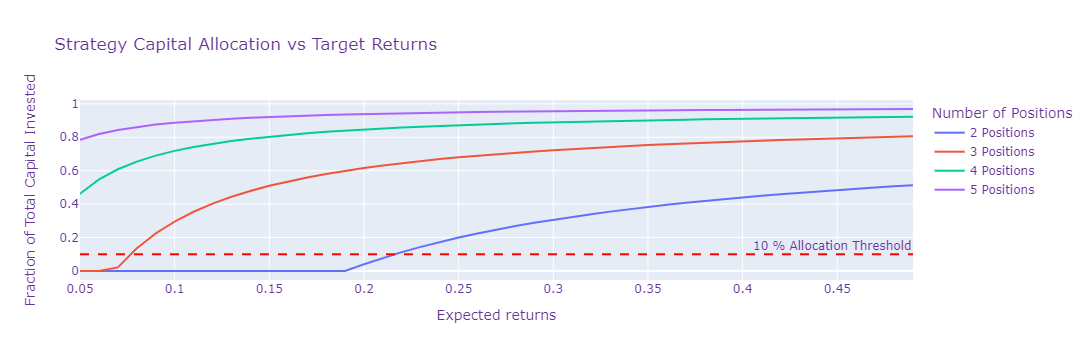

In [145]:
expected_gain_range = np.arange(0.05, 0.5, 0.01)

position_range = np.arange(2, 6)

p_not_breakeven = 0.4
# num_positions = 2
fig = go.Figure()
for num_positions in position_range:
    
    p = 1 - p_not_breakeven**num_positions
    gain_fraction_df =  pd.DataFrame({"Capital Fraction":np.apply_along_axis(lambda expected_gain: p -  (1-p) / expected_gain, 0, expected_gain_range),
                                  "Expected Gain":expected_gain_range})
    gain_fraction_df.loc[gain_fraction_df['Capital Fraction']<0, 'Capital Fraction'] = 0
    # gain_fraction_df.loc[gain_fraction_df['Capital Fraction'].gt(0.05).idxmax(), "Expected Gain"]

    fig.add_trace(go.Scatter(x=gain_fraction_df["Expected Gain"], y=gain_fraction_df["Capital Fraction"],
                    mode='lines',
                    name='%d Positions'%num_positions))
    
fig.add_hline(0.1, line_dash="dash", line_color="red", annotation_text='10 % Allocation Threshold')
fig.update_layout(
    title="Strategy Capital Allocation vs Target Returns",
    xaxis_title="Expected returns",
    yaxis_title="Fraction of Total Capital Invested",
    legend_title="Number of Positions",
    font=dict(
#         family="Courier New, monospace",
        size=12,
        color="RebeccaPurple"
    )
)

fig.show()

Considering partial losses : Loss of 1 position

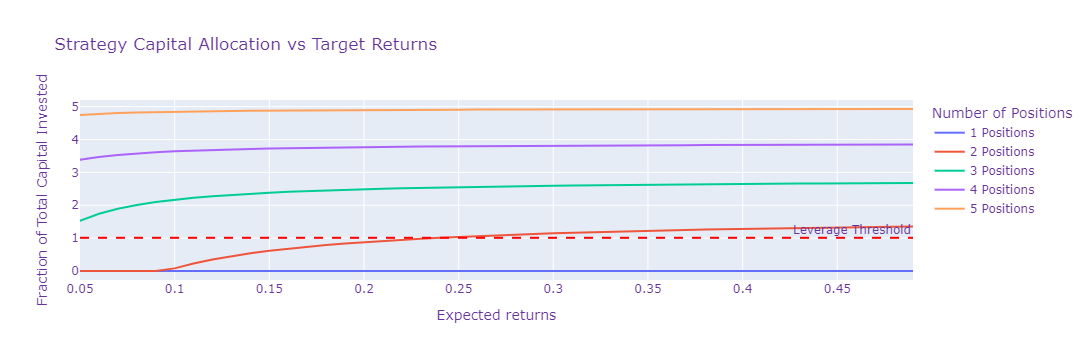

In [146]:
expected_gain_range = np.arange(0.05, 0.5, 0.01)

position_range = np.arange(1, 6)

p_not_breakeven = 0.4
# num_positions = 2
fig = go.Figure()
for num_positions in position_range:
    
    p = 1 - p_not_breakeven**num_positions
    gain_fraction_df =  pd.DataFrame({"Capital Fraction":np.apply_along_axis(lambda expected_gain: p/(1/num_positions) -  (1-p) / expected_gain, 0, expected_gain_range),
                                  "Expected Gain":expected_gain_range})
    gain_fraction_df.loc[gain_fraction_df['Capital Fraction']<0, 'Capital Fraction'] = 0
    # gain_fraction_df.loc[gain_fraction_df['Capital Fraction'].gt(0.05).idxmax(), "Expected Gain"]

    fig.add_trace(go.Scatter(x=gain_fraction_df["Expected Gain"], y=gain_fraction_df["Capital Fraction"],
                    mode='lines',
                    name='%d Positions'%num_positions))
    
fig.add_hline(1.01, line_dash="dash", line_color="red", annotation_text='Leverage Threshold')
fig.update_layout(
    title="Strategy Capital Allocation vs Target Returns",
    xaxis_title="Expected returns",
    yaxis_title="Fraction of Total Capital Invested",
    legend_title="Number of Positions",
    font=dict(
#         family="Courier New, monospace",
        size=12,
        color="RebeccaPurple"
    )
)

fig.show()

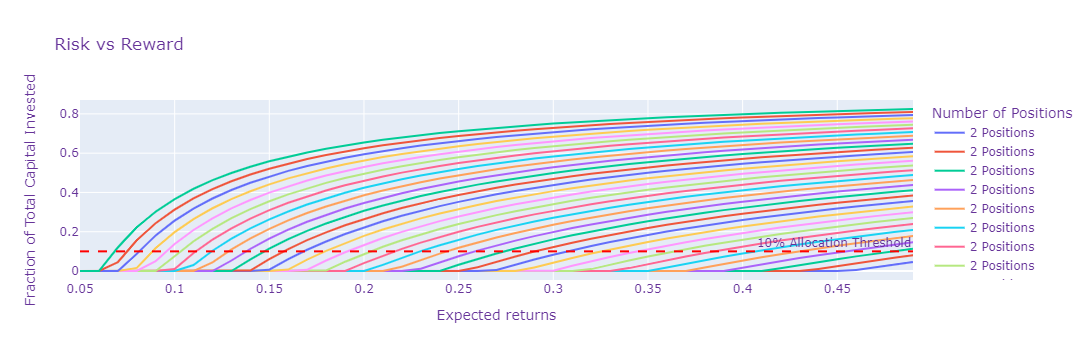

In [140]:
# p_not_breakeven = 0.4
# num_positions = 2
expected_gain = 0.1
position_range = np.arange(1, 6)
p_range = np.arange(0.56, 0.24, -0.01)
fig = go.Figure()
for p_not_breakeven in p_range:
    
    for num_positions in position_range:
    
        p = 1 - p_not_breakeven**num_positions
        p/(1/num_positions) - p_not_breakeven/
#     gain_fraction_df =  pd.DataFrame({"Capital Fraction":np.apply_along_axis(lambda expected_gain: p -  (1-p) / expected_gain, 0, expected_gain_range),
#                                   "Expected Gain":expected_gain_range})
#     gain_fraction_df.loc[gain_fraction_df['Capital Fraction']<0, 'Capital Fraction'] = 0
#     # gain_fraction_df.loc[gain_fraction_df['Capital Fraction'].gt(0.05).idxmax(), "Expected Gain"]

    fig.add_trace(go.Scatter(x=gain_fraction_df["Expected Gain"], y=gain_fraction_df["Capital Fraction"],
                    mode='lines',
                    name='%d Positions'%num_positions))
    
fig.add_hline(0.1, line_dash="dash", line_color="red", annotation_text='10% Allocation Threshold')
fig.update_layout(
    title="Risk vs Reward",
    xaxis_title="Expected returns",
    yaxis_title="Fraction of Total Capital Invested",
    legend_title="Number of Positions",
    font=dict(
#         family="Courier New, monospace",
        size=12,
        color="RebeccaPurple"
    )
)

fig.show()

The more pairs we hold